# Introduction

<div style="color:white;display:fill;
            background-color:#506f3f;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>1.1 Objectives</b></p>
</div>

I'm very excited to participate in kaggle's Getting Started with **NLP**.
In this competition, we’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. 

We have access to a dataset of 10,000 tweets that were hand classified. 

In this notebook, I've performed below action items:
* EDA of data to get insight 
* Preprocessing of text
* implementation of advance version of embedding from tf-hub
* build a dense layerd model

<div style="color:white;display:fill;
            background-color:#506f3f;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>1.2 Loading Libraries</b></p>
</div>


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from sklearn import model_selection
from IPython.display import display
from collections import defaultdict
from collections import  Counter

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm_notebook

from wordcloud import STOPWORDS, WordCloud
from termcolor import colored


import warnings
warnings.filterwarnings(action="ignore")
tf.__version__

2024-03-02 05:07:23.518915: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-02 05:07:23.519093: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-02 05:07:23.712864: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'2.15.0'

# 2. Data Overview 



<div style="color:white;display:fill;
            background-color:#506f3f;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>2.1 Loading the Data</b></p>
</div>

In [2]:
df_train = pd.read_csv("../input/nlp-getting-started/train.csv")
df_test = pd.read_csv("../input/nlp-getting-started/test.csv")

df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
print('There are {} rows and {} columns in train'.format(df_train.shape[0], df_train.shape[1]))
print('There are {} rows and {} columns in train'.format(df_test.shape[0],df_test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in train


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


<div style="color:white;display:fill;
            background-color:#506f3f;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>2.2  Summary Statistics</b></p>
</div>

In [5]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,7613.0,5441.934848,3137.11609,1.0,2734.0,5408.0,8146.0,10873.0
target,7613.0,0.429660,0.49506,0.0,0.0,0.0,1.0,1.0


In [6]:
df_train.describe(include="O").T

,count,unique,top,freq
keyword,7552,221,fatalities,45
location,5080,3341,USA,104
text,7613,7503,11-Year-Old Boy Charged With Manslaughter of T...,10


In [7]:
df_train[df_train.text.str.contains("Boy Charged")][["text", "target", "location"]]

,text,target,location
3578,11-Year-Old Boy Charged With Manslaughter of T...,1,NaN
3589,11-Year-Old Boy Charged With Manslaughter of T...,1,Varanasi
3591,11-Year-Old Boy Charged With Manslaughter of T...,1,Thane
3597,11-Year-Old Boy Charged With Manslaughter of T...,1,NaN
3600,11-Year-Old Boy Charged With Manslaughter of T...,1,NaN
3603,11-Year-Old Boy Charged With Manslaughter of T...,1,NaN
3604,11-Year-Old Boy Charged With Manslaughter of T...,1,Bangalore
3610,11-Year-Old Boy Charged With Manslaughter of T...,1,Dimapur
3613,11-Year-Old Boy Charged With Manslaughter of T...,1,NaN
3614,11-Year-Old Boy Charged With Manslaughter of T...,1,NaN


In [8]:
## Removing the duplicate texts
df_train.drop_duplicates(subset=["text", "location", "target"], inplace=True)
print('There are {} rows and {} columns in train'.format(df_train.shape[0], df_train.shape[1]))

There are 7543 rows and 5 columns in train



<div style="color:white;display:fill;
            background-color:#506f3f;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>2.3 Target Class Distribution</b></p>
</div>

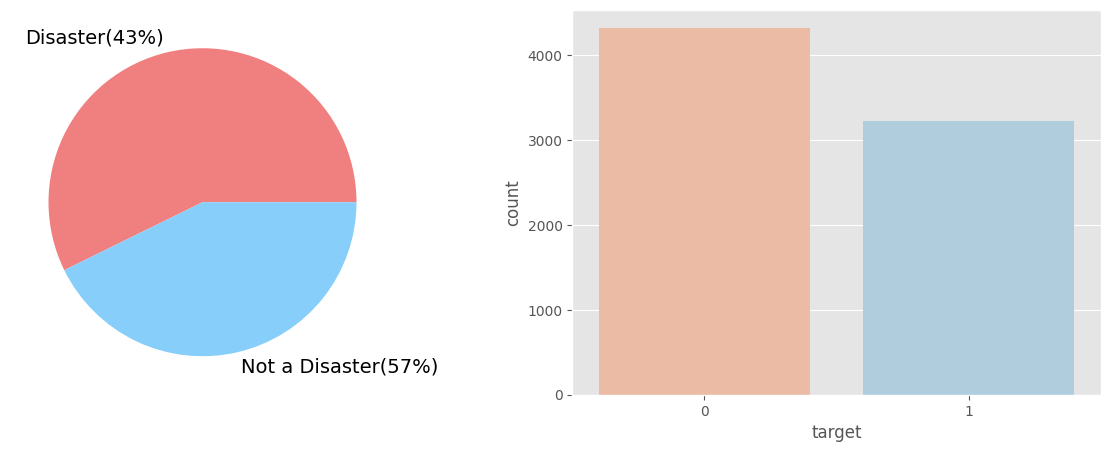

In [9]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
df_train.target.value_counts().plot(kind="pie",
                                           labels=["Disaster(43%)", "Not a Disaster(57%)"],
                                           colors=['lightcoral','lightskyblue'],
                                           fontsize=14,
                                           ylabel="");

plt.subplot(1, 2, 2)
sns.countplot(x="target",data=df_train, palette="RdBu")
plt.show()

<div style="color:white;display:fill;
            background-color:#506f3f;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>2.4 Other Features distribution</b></p>
</div>


### 1. Tweets length

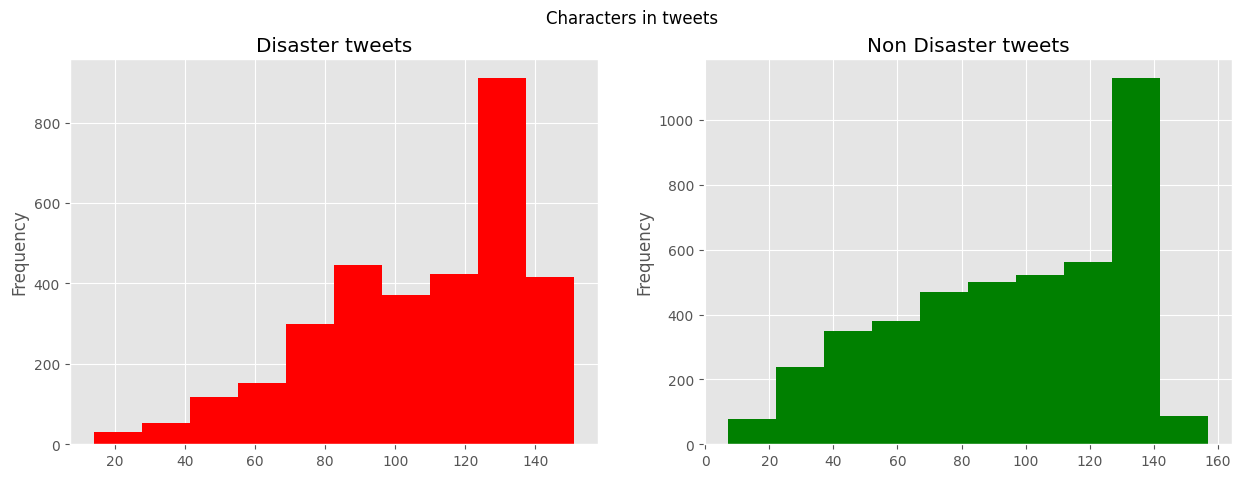

In [10]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
df_train.query("target==1")["text"].str.len().plot(kind="hist",
                                                  color="red",
                                                  title="Disaster tweets");

plt.subplot(1, 2, 2)
df_train.query("target==0")["text"].str.len().plot(kind="hist",
                                                  color="green",
                                                  title="Non Disaster tweets");

plt.suptitle('Characters in tweets')
plt.show()

### 2. Words in a tweet

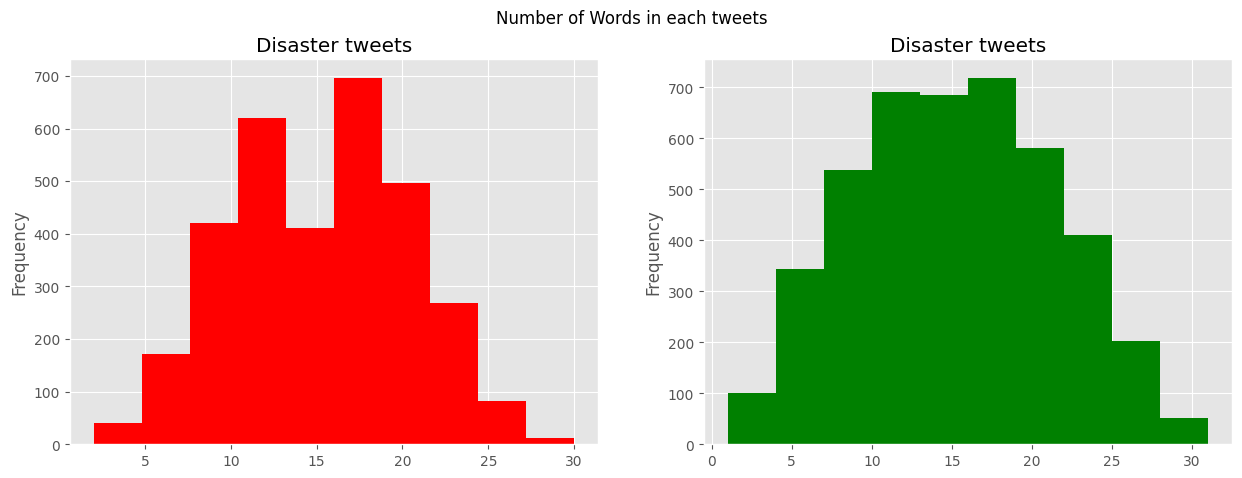

In [11]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
df_train.query("target==1").text.map(lambda x: len(x.split())).plot(kind="hist",
                                                                    color="red",
                                                                    title="Disaster tweets");

plt.subplot(1, 2, 2)
df_train.query("target==0").text.map(lambda x: len(x.split())).plot(kind="hist",
                                                                    color="green",
                                                                    title="Disaster tweets");
plt.suptitle('Number of Words in each tweets')
plt.show()

### 3. Average length of each word in a tweet

In [12]:
df_train.query("target==1")["text"].str.split().map(lambda x: [len(i) for i in x])[:5]

0             [3, 5, 3, 3, 6, 2, 4, 11, 3, 5, 7, 2, 3]
1                                [6, 4, 4, 2, 5, 5, 6]
2    [3, 9, 5, 2, 8, 2, 6, 3, 5, 8, 2, 9, 2, 5, 10,...
3                          [6, 6, 7, 10, 10, 6, 2, 10]
4    [4, 3, 4, 4, 5, 4, 4, 7, 2, 5, 4, 10, 5, 4, 1, 6]
Name: text, dtype: object

In [13]:
df_train.query("target==1")["text"].str.split().map(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x))[:5]

0    4.384615
1    4.571429
2    5.090909
3    7.125000
4    4.500000
Name: text, dtype: float64

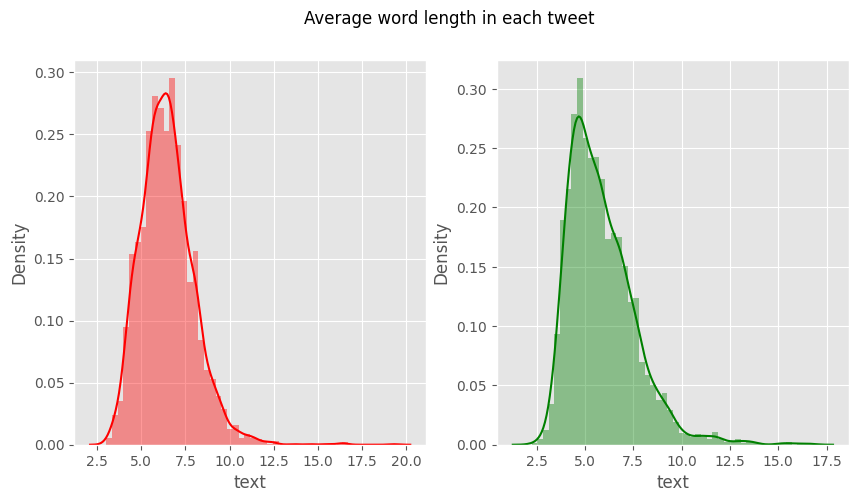

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

each_words_len = df_train.query("target==1").text.str.split().map(lambda x: [len(i) for i in x])
sns.distplot(each_words_len.map(lambda x: np.mean(x)), kde=True, ax=axes[0], color="red");

each_words_len = df_train.query("target==0").text.str.split().map(lambda x: [len(i) for i in x])
sns.distplot(each_words_len.map(lambda x: np.mean(x)), kde=True, ax=axes[1], color='green');

fig.suptitle('Average word length in each tweet');

### 4. Punctuation used in tweets

In [15]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

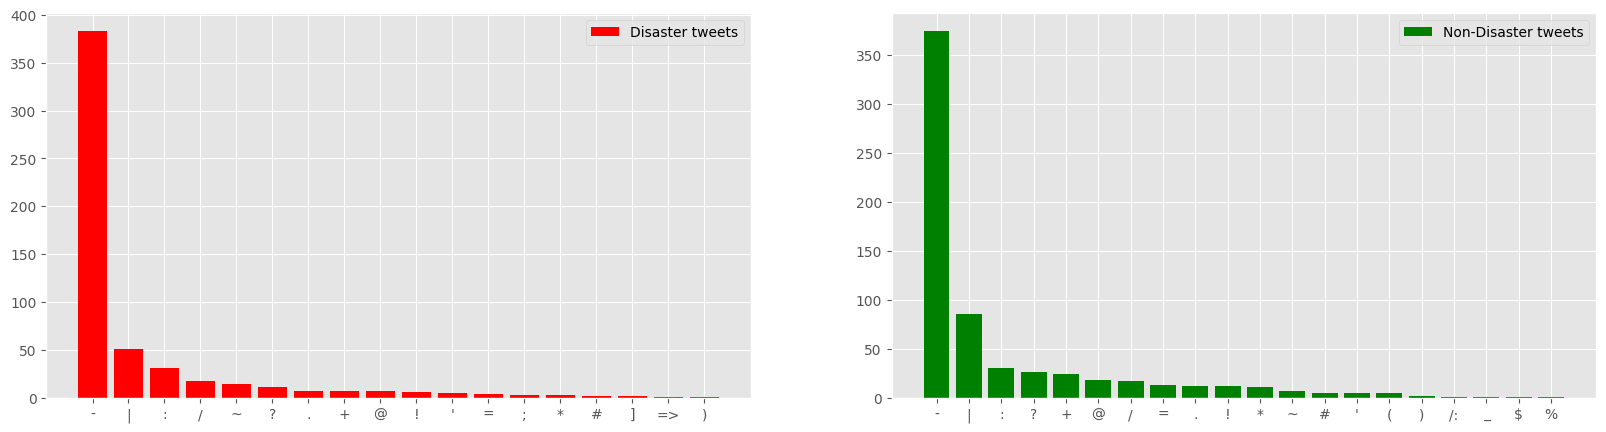

In [16]:
import string
def plot_punctuations(df, target):
    
    punctations_dict = defaultdict(int)
    
    for text in df[df["target"]==target].text:
        for token in text.split():
            if token in string.punctuation:
                punctations_dict[token] +=1

    return dict(sorted(punctations_dict.items(), key=lambda x: x[1], reverse=True))


dt_punctuations = plot_punctuations(df_train, target=1)
ndt_punctuations = plot_punctuations(df_train, target=0)

plt.figure(figsize=(20, 5))
plt.subplot(121)
x1, y1 = zip(*dt_punctuations.items())
plt.bar(x1,y1, color="red", label="Disaster tweets")
plt.legend()

plt.subplot(122)
x2, y2 = zip(*ndt_punctuations.items())
plt.bar(x2, y2, color="green", label="Non-Disaster tweets")
plt.legend()
plt.show()

### Remarks:
- Most the diaster and non-diaster tweets have moreover same punctuations used.

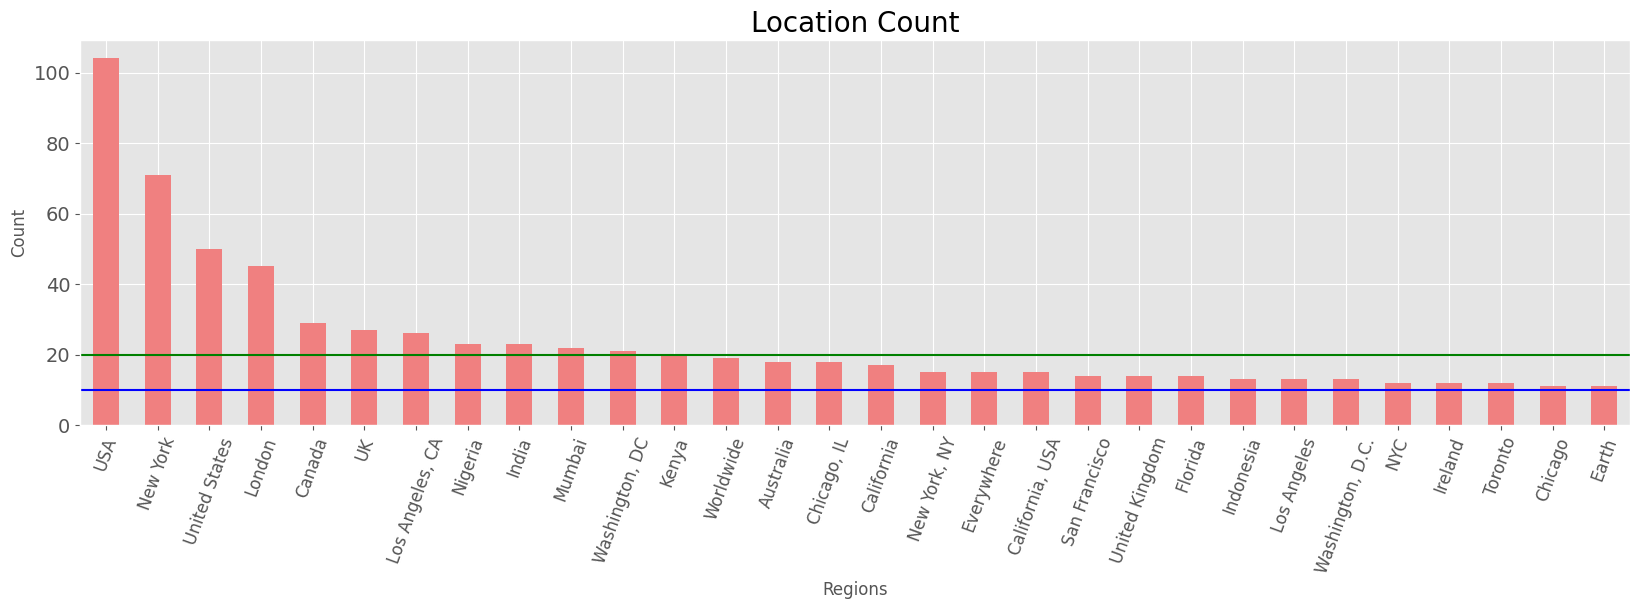

In [17]:
plt.figure(figsize=(20, 5))
df_train.location.value_counts().sort_values(ascending=False)[:30].plot(kind="bar",
                                                                        color='lightcoral',
                                                                        linewidth=2,
                                                                        fontsize=14);
plt.title('Location Count', fontsize = 20)
plt.axhline(y=20, color="green")
plt.axhline(y=10, color="blue")
plt.xlabel('Regions', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.xticks(fontsize=12, rotation=70);

# Creating Word Clouds

In [18]:
stop_words= set(stopwords.words("english"))

# updating the stopwords considering the 
stop_words.update(['https', 'http', 'amp', 'CO', 't', 'u', 'new', "I'm", "would"])

wc = WordCloud(width=800,
               height=400,
               max_words=200,
               stopwords=stop_words,
               background_color= "black", 
               colormap="Paired",
               max_font_size=150)


Word Cloud for Disaster Tweets


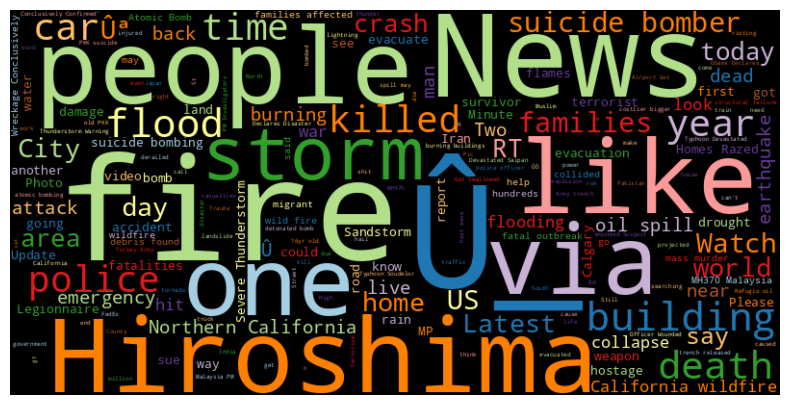


Word Cloud for Non-Disaster Tweets


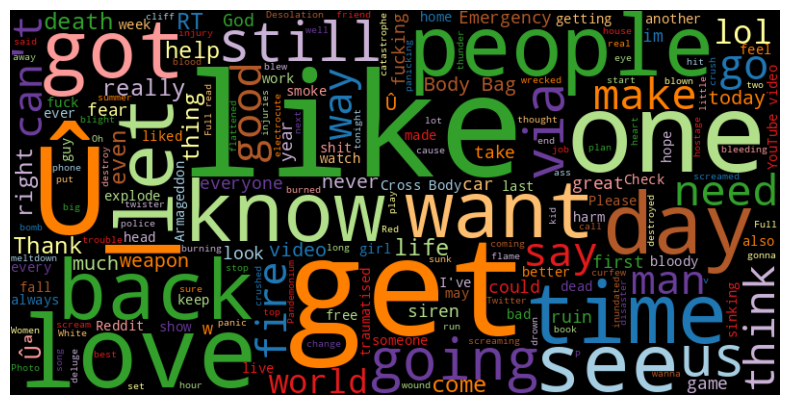

In [19]:
disaster_tweets_text = df_train.query("target==1").text
concat_disaster_tweets_text = disaster_tweets_text.str.cat(sep=" ")  # str.cat -- string concatenation

non_disaster_tweets_text = df_train.query("target==0").text
concat_non_disaster_tweets_text = non_disaster_tweets_text.str.cat(sep=" ")

print('\033[1m'"\nWord Cloud for Disaster Tweets"'\033[0m')
wc.generate(concat_disaster_tweets_text)
plt.figure(figsize=(12, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

print('\033[1m'"\nWord Cloud for Non-Disaster Tweets"'\033[0m')
wc.generate(concat_non_disaster_tweets_text)
plt.figure(figsize=(12, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

---
# Data Cleaning:

### Merging the df_train and df_test for preprocessing

In [20]:
df_train["istrain"] = True
df_test["istrain"] = False

In [21]:
df_train.shape[0] +  df_test.shape[0]

10806

In [22]:
df = pd.concat([df_train, df_test], axis=0)
df

,id,keyword,location,text,target,istrain
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,True
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,True
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,True
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,True
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,True
...,...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN,False
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN,False
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN,False
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN,False


### 1. Removing URLs

In [23]:
example = df_train.loc[57, "text"]
example

'Set our hearts ablaze and every city was a gift And every skyline was like a kiss upon the lips @\x89Û_ https://t.co/cYoMPZ1A0Z'

In [24]:
def remove_URLs(text):
    return re.sub(r'http\S+', ' ', text,  flags=re.MULTILINE)

remove_URLs(example)

'Set our hearts ablaze and every city was a gift And every skyline was like a kiss upon the lips @\x89Û_  '

In [25]:
df['text']= df['text'].apply(lambda x : remove_URLs(x))

### 2. Remove special characters/punctions

In [26]:
example = "Set our hearts ablaze and every city was a gift And every skyline was like a kiss upon the lips @\x89Û_"

In [27]:
def lower_text_and_remove_special_chars(text):
    text = text.lower().strip()
    return re.sub(r"\W+", " ", text)

lower_text_and_remove_special_chars(example)

'set our hearts ablaze and every city was a gift and every skyline was like a kiss upon the lips û_'

In [28]:
df['text']= df['text'].apply(lambda x : lower_text_and_remove_special_chars(x))

### 3. Removing HTML tags

In [29]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

In [30]:
from bs4 import BeautifulSoup

def remove_html_tags(text):
    return BeautifulSoup(text).get_text()

print(remove_html_tags(example))


Real or Fake
Kaggle 
getting started



In [31]:
df['text']= df['text'].apply(lambda x : remove_html_tags(x))

### 4. Removing Emojis


In [32]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [33]:
df['text']= df['text'].apply(lambda x : remove_emoji(x))

### 5. decontraction

In [34]:
example = "I'm the king!"

In [35]:
def decontraction_text(text):    
    # performing de-contraction
    text = text.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                .replace("he's", "he is").replace("she's", "she is").replace("'s", "is")\
                .replace("'m", "am").replace("'t", "not")\
                .replace("'ll", " will")
    
    return text

decontraction_text(example)

'Iam the king!'

In [36]:
df['text']= df['text'].apply(lambda x : decontraction_text(x))

### Spelling Correction

In [37]:
!pip install pyspellchecker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 50.6 MB/s eta 0:00:00


In [38]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "corect me plese"
correct_spellings(text)

'correct me please'

---
# Data Preparation for model

In [39]:
train = df.query("istrain==True")
train.shape

(7543, 6)

In [40]:
test = df.query("istrain==False")
test.shape

(3263, 6)

In [41]:
train

,id,keyword,location,text,target,istrain
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1.0,True
1,4,NaN,NaN,forest fire near la ronge sask canada,1.0,True
2,5,NaN,NaN,all residents asked to shelter in place are be...,1.0,True
3,6,NaN,NaN,13 000 people receive wildfires evacuation ord...,1.0,True
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1.0,True
...,...,...,...,...,...,...
7605,10864,NaN,NaN,on the flip side i m at walmart and there is a...,1.0,True
7606,10866,NaN,NaN,suicide bomber kills 15 in saudi security site...,1.0,True
7608,10869,NaN,NaN,two giant cranes holding a bridge collapse int...,1.0,True
7611,10872,NaN,NaN,police investigating after an e bike collided ...,1.0,True


In [42]:
# initiating the input and labels
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(train.text,
                                                                      train.target, 
                                                                      test_size=0.15, 
                                                                      random_state=42, 
                                                                      stratify=train.target) 

train_sentences = np.array(x_train) 
train_labels = np.array(y_train)

valid_sentences = np.array(x_valid)
valid_labels = np.array(y_valid)

# Building the Model and Word Embedding

In [43]:
import tensorflow_hub as hub

class UniversalSentenceEncoderLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(UniversalSentenceEncoderLayer, self).__init__(**kwargs)
        self.encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")
    
    def call(self, inputs):
        return self.encoder(inputs)

In [44]:
def get_model():
    inputs = keras.Input(shape=(), dtype=tf.string, name='text')
    x = UniversalSentenceEncoderLayer()(inputs)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid", name="output")(x)

    model = keras.Model(inputs, outputs, name="USE_dense_model_1")
    
    model.compile(
        optimizer= keras.optimizers.Adam(),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    
    return model

model = get_model()
model.summary()

Model: "USE_dense_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text (InputLayer)               │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ universal_sentence_encoder_lay… │ (None, 512)            │             0 │
│ (UniversalSentenceEncoderLayer) │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,449 (64.25 KB)

 Trainable params: 16,449 (64.25 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
num_epochs=15
batch_size=32

callbacks = [
        keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')
]

history = model.fit(x=train_sentences,
                    y=train_labels,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    validation_data=(valid_sentences, valid_labels),
                    callbacks=callbacks)

Epoch 1/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 108s 350ms/step - accuracy: 0.6890 - loss: 0.6289 - val_accuracy: 0.8154 - val_loss: 0.4484
Epoch 2/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 61s 304ms/step - accuracy: 0.7942 - loss: 0.4480 - val_accuracy: 0.8251 - val_loss: 0.4213
Epoch 3/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 81s 301ms/step - accuracy: 0.8190 - loss: 0.4246 - val_accuracy: 0.8286 - val_loss: 0.4131
Epoch 4/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 83s 307ms/step - accuracy: 0.8126 - loss: 0.4196 - val_accuracy: 0.8322 - val_loss: 0.4100
Epoch 5/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 87s 332ms/step - accuracy: 0.8061 - loss: 0.4289 - val_accuracy: 0.8322 - val_loss: 0.4055
Epoch 6/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 63s 313ms/step - accuracy: 0.8157 - loss: 0.4177 - val_accuracy: 0.8339 - val_loss: 0.4021
Epoch 7/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 79s 298ms/step - accuracy: 0.8173 - loss: 0.4099 - val_accuracy: 0.8330 - val_loss: 0.4000
Epoch 8/15
201/201 ━━━━━━━━━━━━━━━━━━━━ 82s 299ms/step - accuracy: 0.8291 - loss: 

In [46]:
test_sequences = np.array(test.text)
preds = model.predict(test_sequences)
preds_final = tf.squeeze(tf.round(preds))
preds_final = np.array(preds_final, dtype="int32")

102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 345ms/step


In [47]:
len(preds_final)

3263

In [48]:
submission = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")
submission.target = preds_final



submission.to_csv("submission.csv", index=False)
print("Submission csv file generated...")

Submission csv file generated...
